# Clustering Countries - Induced Effects

In [1]:
%matplotlib notebook

from IPython.display import display_html 

from tools import Preprocessing, Clustering, benchClustering, plotBarh

import pandas as pd
import numpy as np

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import hdbscan
from scipy.cluster import hierarchy


from fancyimpute import KNN

import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tl

import matplotlib as mpl
import matplotlib.pyplot as plt
import bqplot as bqp
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pylab

import ipyvolume as ipv
from ipywidgets import FloatSlider, ColorPicker, VBox, jslink


sns.set(context='notebook', style='whitegrid', font='sans-serif',
        palette='muted', font_scale=1, color_codes=True, rc=None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 10000)

Using TensorFlow backend.


In [2]:
# import the csv dataset as a pandas DataFrame
# df = pd.read_csv('data/full_data.csv')
#df.columns
# list(df.columns)

"**Induced effects** result from households spending some of the additional income they receive in the local area." [Wayne P. Miller]

So, what does the induced effect of an **off-shore oil platform** depends upon?


1. Presenza di un pool di lavoratori skillati da cui attingere (proporzioni di forza lavoro per livello professionale)
2. 
    

### Clustering variables

1. **Households Consumption**, **Inflation Rate** (proxy of Interest Rates), **Employment Rate** (Jobs Stability), **GDP**
2. **Imports of Goods and Serivices**
3. Taxes?
4. **Manufactoring Value Added per capita** 

### Correlation-based distance

Correlation-based distance considers two countries to be similar if their features are highly correlated, even though the observed values may be far apart in terms of Euclidean distance. The distance between two objects is 0 when they are perfectly correlated.

In [3]:
varlist = [
    'GDP_constantUS$_2014',
    'GDP_constantUS$_2015',
    'GDP_constantUS$_2016',
    'HouseholdsConsumption_constantUS$_2014',
    'HouseholdsConsumption_constantUS$_2015',
    'HouseholdsConsumption_constantUS$_2016',
    'ImportsGoodsServices_%GDP_2014',
    'ImportsGoodsServices_%GDP_2015',
    'ImportsGoodsServices_%GDP_2016',
    'MVApc_constantUS$_2010',
    'MVApc_constantUS$_2015',
    'Inflation_ConsumerPrices_annual%_2014',
    'Inflation_ConsumerPrices_annual%_2015',
    'Inflation_ConsumerPrices_annual%_2016',
    'Employment_%total_2014',
    'Employment_%total_2015',
    'Employment_%total_2016',
    'Employment_%total_2017',
#    'MVApc_constantUS$_2015',
#   'Production_Oil_bpd_2014',
#   'Production_Oil_bpd_2015',
          ]

In [4]:
prep = Preprocessing('data/full_data.csv',
                     varlist=varlist, verbose=True)
prep.exportCSV('data/cleaned_data_petroleum.csv', impute=True)

MISSING VALUES FOR EACH FEATURE:
HouseholdsConsumption_constantUS$_2016    6
HouseholdsConsumption_constantUS$_2015    5
Inflation_ConsumerPrices_annual%_2016     4
HouseholdsConsumption_constantUS$_2014    4
MVApc_constantUS$_2015                    3
MVApc_constantUS$_2010                    3
ImportsGoodsServices_%GDP_2016            3
Inflation_ConsumerPrices_annual%_2015     2
Inflation_ConsumerPrices_annual%_2014     2
ImportsGoodsServices_%GDP_2015            2
ImportsGoodsServices_%GDP_2014            1
GDP_constantUS$_2016                      1
GDP_constantUS$_2015                      1
dtype: int64 

MISSING VALUES FOR EACH COUNTRY:
Country Code
TKM    11
LBY    9 
VEN    6 
IRQ    4 
TUN    3 
TLS    2 
OMN    1 
COG    1 
dtype: int64


Let's visualize our dataset a bit:

In [5]:
# for c in prep.df.columns[1:]:
#     plotBarh(df=prep.df, by_column=c )

In [6]:
data = Clustering('data/cleaned_data_petroleum.csv', verbose=False)

/home/lupol/tensorflow/local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:164: UserWarning:

Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.



CUMULATIVE PROPORTION OF VARIANCE EXPLAINED BY PCs


<IPython.core.display.Javascript object>


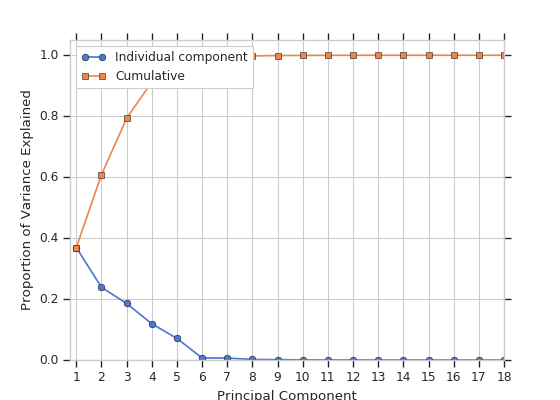

<IPython.core.display.Javascript object>


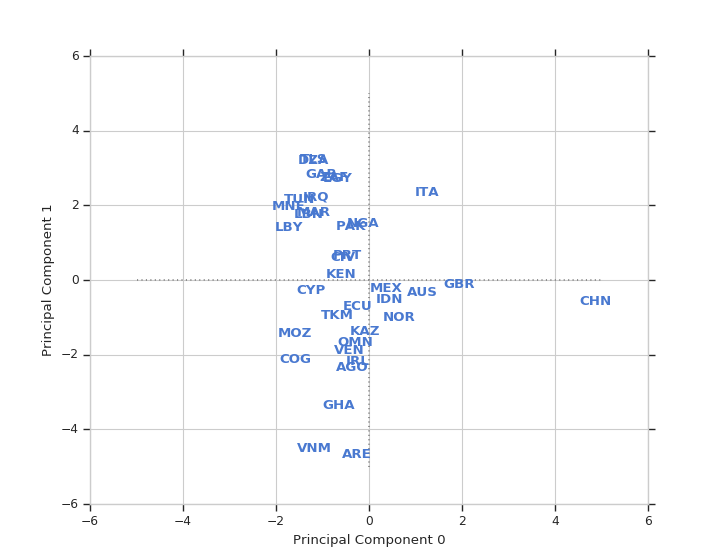

In [7]:
data.getPC()
data.plotAlongPC(pc1=0, pc2=1, xlim=[-6, 6], ylim=[-6, 6], loadings=False, clustering=None)

In [9]:
x = data.df_pc.iloc[:, 0]
y = data.df_pc.iloc[:, 1]
z = data.df_pc.iloc[:, 2]

selected = None
ipv.figure()
scatter = ipv.pylab.scatter(x, y, z, marker="sphere", color = 'red', size=5, size_selected=8, selected=selected)
# ipv.pylab.xyzlabel(x.name, y.name, z.name)

size = FloatSlider(min=0, max=30, step=0.1)
size_selected = FloatSlider(min=0, max=30, step=0.1)
color = ColorPicker()
color_selected = ColorPicker()
jslink((scatter, 'size'), (size, 'value'))
jslink((scatter, 'size_selected'), (size_selected, 'value'))
jslink((scatter, 'color'), (color, 'value'))
jslink((scatter, 'color_selected'), (color_selected, 'value'))

In [10]:
print('x = PC', x.name)
print('y = PC', y.name)
print('z = PC', z.name)
VBox([ipv.gcc(), size, size_selected, color, color_selected])

x = PC 0
y = PC 1
z = PC 2


Let's implement various clustering techniques and compare their results:
 - **K-Means CLustering** (spherical clusters, fixed number)
 - **Hierarchical Agglomerative Clustering** (spherical clusters, adaptive)
 - **Gaussian Mixtures Model** (elliptical clusters, fixed number)
 - **Bayesian Gaussian Mixtures Model** (elliptical clusters, adaptive)

Some more information on the clustering techniques:

- **K-Means CLustering** : clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. 
- **Ward Hierarchical Clustering** : minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
- **Gaussian Mixtures Model** : a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.
- **Bayesian Gaussian Mixtures Model** : implements a variant of the Gaussian mixture model with variational inference algorithms. 

![caption](files/comparing_clustering_methods.png)

In [11]:
# on_PC = 0
# n_init = 100
# k_min = 5
# k_max = 30
# silh, calha = data.multipleKmeans(k_min=5, k_max=30, on_PC=0, n_init=n_init)

In [12]:
# k_clusters = 11
# data.kmeans(n_clusters=k_clusters, on_PC=on_PC, n_init=n_init)
# k_clusters = 10
# data.kmeans(n_clusters=k_clusters, on_PC=on_PC, n_init=n_init)
# data.clusterings['kmeans'+str(n_clusters)]

In [13]:
# data.min_BIC

In [14]:
# data.gmBIC(n_min=5, n_max=30, covariance_type='full', n_init=n_init, on_PC=on_PC)

In [15]:
# n_components = 21
# data.gaussianMixture(n_components, covariance_type='full', n_init=n_init, on_PC=0)
# data.bayesianGaussianMixture(n_components, covariance_type='full', n_init=n_init, on_PC=0)

<IPython.core.display.Javascript object>


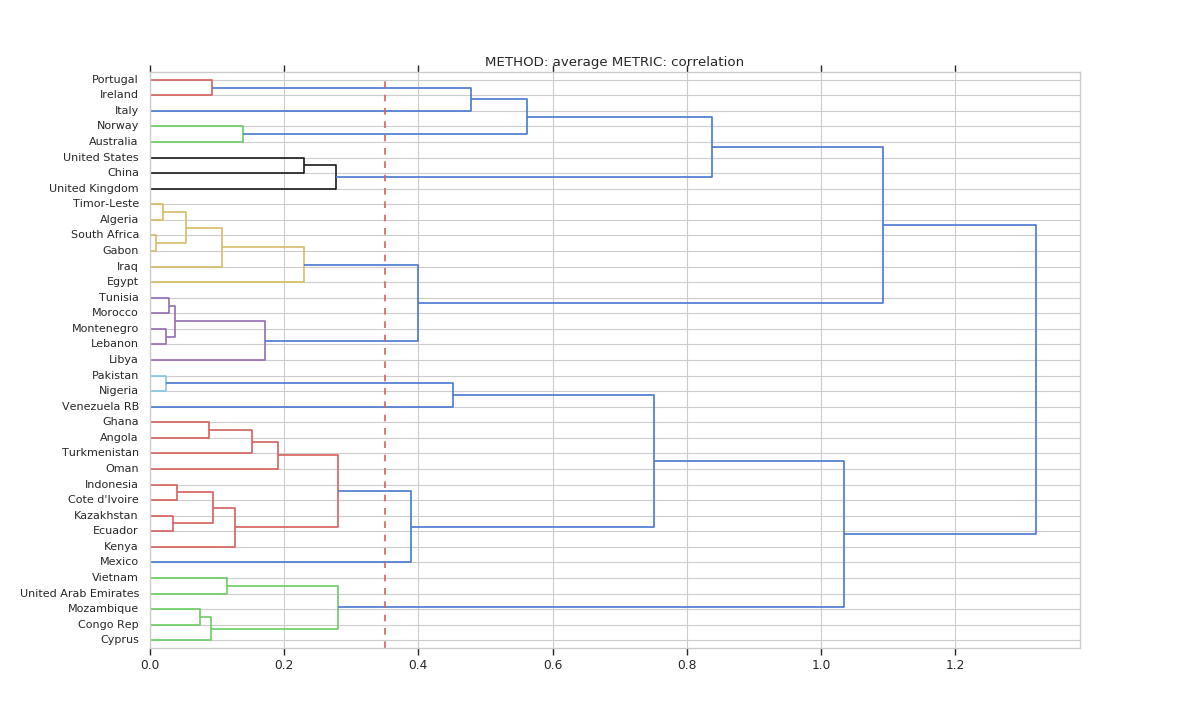

In [16]:
data.hierarchicalClustering(metric='correlation', method='average', threshold=0.35, on_PC=0, heatmap=False)

<IPython.core.display.Javascript object>


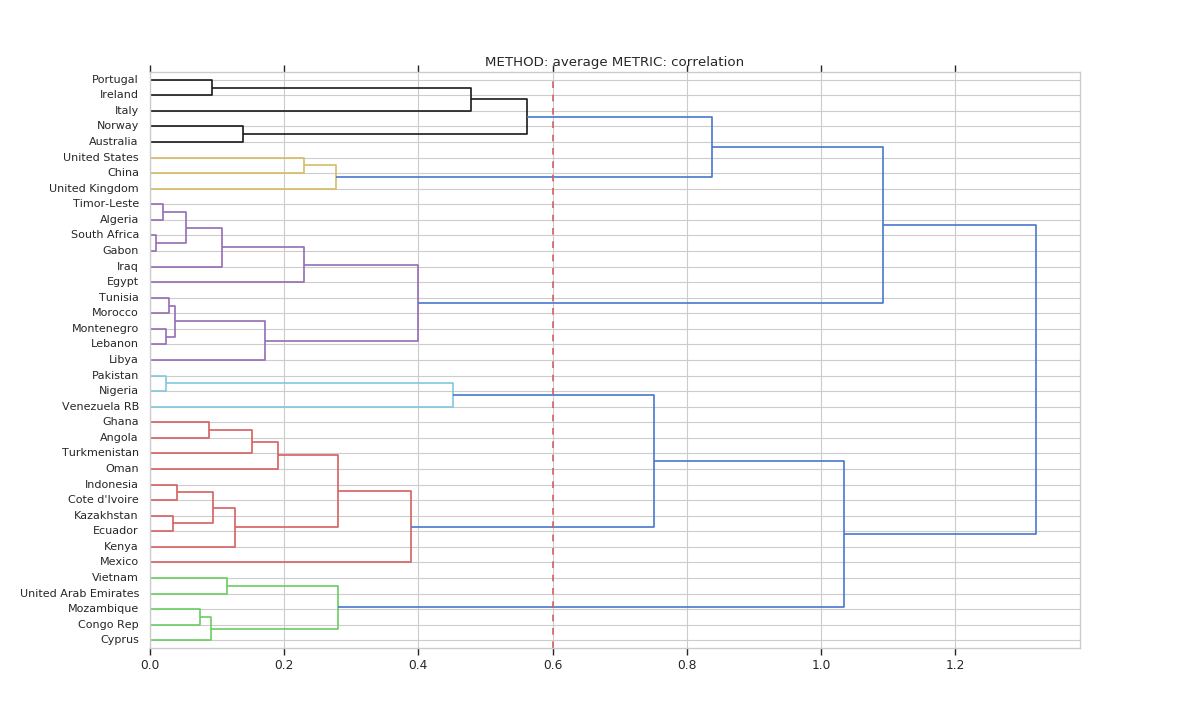

In [21]:
data.hierarchicalClustering(metric='correlation', method='average', threshold=0.6, on_PC=0, heatmap=False)

<IPython.core.display.Javascript object>


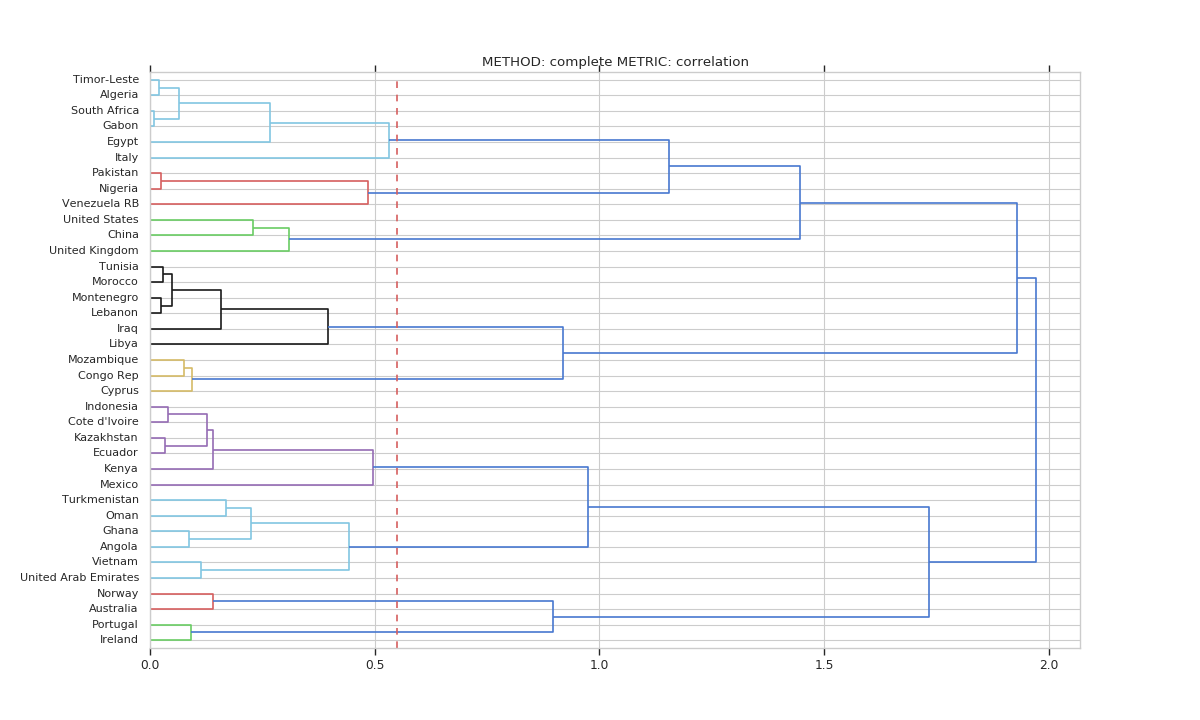

In [20]:
data.hierarchicalClustering(metric='correlation', method='complete', threshold=0.55, on_PC=0, heatmap=False)

In [29]:
#data.hierarchicalClustering(metric='euclidean', method='complete', threshold=1.5, on_PC=on_PC, heatmap=False)

After the analysis of:
- the best **number of clusters** for K-Means and the Gaussian Mixture Model
- the best **linkage methods and thresholds** for Hierarchical Clustering

The following clusterings have been computed:

In [24]:
# del data.clusterings_labels['hc_complete_correlation_4']
sorted(data.clusterings_labels.keys())

['hc_average_correlation_0.35',
 'hc_average_correlation_0.6',
 'hc_complete_correlation_0.55']

In [27]:
data.clusterings_labels.keys()

dict_keys(['hc_average_correlation_0.6', 'hc_average_correlation_0.35', 'hc_complete_correlation_0.55'])

In [38]:
# Compare multiple clusterings through 3D plotting

fig = tl.make_subplots(rows=1, cols=3,
                          print_grid=False,
                          specs=[[{'is_3d': True}, {'is_3d': True}, {'is_3d': True}]])

X = data.df_pc.values

fignum = 1
row = 1
for name, labels in data.clusterings_labels.items():
    # generate 3D scatter plot
    trace = go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2],
                         hovertext=data.country_names,
                         name=name,
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                             cauto=True,
                             color=labels.astype(np.float),
                             colorscale='Rainbow',
                             size = 3.5,
                             opacity=0.99999999999999),
                         hoverlabel=dict(bgcolor='red'))
    col = abs(fignum % 2 - 2)
    # print('name: ', name, 'fignum=', fignum, 'row=',row,'col=',col)
    # append plot to the list
    fig.append_trace(trace, row=1, col=fignum)
    # update indices
    if fignum % 2 == 0:
        row += 1
    fignum = fignum + 1


fig['layout'].update()

# set titles to subplots
titles = list(data.clusterings_labels.keys())
fig['layout']['scene'].update(annotations=[dict(z=4, text=titles[0], showarrow=False)])
fig['layout']['scene2'].update(annotations=[dict(z=4, text=titles[1], showarrow=False)])
fig['layout']['scene3'].update(annotations=[dict(z=4, text=titles[2], showarrow=False)])
# fig['layout']['scene4'].update(annotations=[dict(z=4, text=titles[3], showarrow=False)])
# fig['layout']['scene5'].update(annotations=[dict(z=4, text=titles[4], showarrow=False)])
# fig['layout']['scene6'].update(annotations=[dict(z=4, text=titles[5], showarrow=False)])
#fig['layout']['scene7'].update(annotations=[dict(z=4, text=titles[6], showarrow=False)])
#fig['layout']['scene8'].update(annotations=[dict(z=4, text=titles[7], showarrow=False)])


Visual comparison of the clusters:

In [39]:
methods = list(data.clusterings_labels.keys())
n_clusters = [len(np.unique(x)) for x in data.clusterings_labels.values()]
ndf = pd.DataFrame(data=list(zip(methods, n_clusters)), columns=['Methods','N.clusters']).set_index('Methods')

In [40]:
from IPython.display import display
display(ndf)
print('\nx = PC', data.df_pc.columns[0])
print('y = PC', data.df_pc.columns[1])
print('z = PC', data.df_pc.columns[2])
py.iplot(fig)

,N.clusters
Methods,
hc_average_correlation_0.6,6
hc_average_correlation_0.35,11
hc_complete_correlation_0.55,9



x = PC 0
y = PC 1
z = PC 2


In [41]:
# data.plotAlongPC(pc1=0, pc2=1, xlim=[-3, 3], ylim=[-2, 2], loadings=True, clustering='kmeans10')

In [43]:
# display all tables of clusters generated by different methods together
# newdf = np.zeros(len(data.clusterings.keys()))
styler = []
for k in sorted(data.clusterings.keys()):
    styler.append(data.clusterings[k].style.set_table_attributes("style='display:inline'"))
display_html(styler[0]._repr_html_() + styler[1]._repr_html_() + styler[2]._repr_html_() + styler[3]._repr_html_() + styler[4]._repr_html_(), raw=True)

,hc_average_correlation_0.35
Cluster,
1,"['Congo Rep', 'Cyprus', 'Mozambique', 'United Arab Emirates', 'Vietnam']"
2,"['Angola', ""Cote d'Ivoire"", 'Ecuador', 'Ghana', 'Indonesia', 'Kazakhstan', 'Kenya', 'Oman', 'Turkmenistan']"
3,['Mexico']
4,"['Nigeria', 'Pakistan']"
5,['Venezuela RB']
6,"['Lebanon', 'Libya', 'Montenegro', 'Morocco', 'Tunisia']"
7,"['Algeria', 'Egypt', 'Gabon', 'Iraq', 'South Africa', 'Timor-Leste']"
8,"['China', 'United Kingdom', 'United States']"
9,"['Australia', 'Norway']"


# HOVER CHE FUNZIONANO MA UN SOLO PLOT

In [ ]:
# import plotly.plotly as py
# import pandas as pd

# df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/alpha_shape.csv')
# df.head()

# fig = tools.make_subplots(rows=2, cols=3,
#                           print_grid=True,
#                           specs=[[{'is_3d': True}, {'is_3d': True}, {'is_3d': True}],
#                                  [ {'is_3d': True, 'rowspan':1}, None, None]])
# fig = fig.to_dict()
# X = data.df.values

# fignum = 1
# content = []
# for name, labels in data.clusterings_labels.items():
    
#     scatter = dict(
#         mode = "markers",
#         name = name,
#         type = "scatter3d",    
#         x=X[:, 0], y=X[:, 1], z=X[:, 2],
#         marker=dict(
#              cauto=True,
#              color=labels.astype(np.float),
#              colorscale='Rainbow',
#              line=dict(color='black', width=1)),
#         hoverlabel=dict(bgcolor='orange'),
#         hovertext=data.country_names)
    
#     content.append(scatter)

# layout = dict(
#     title = '3d point clustering',
#     scene = dict(
#         xaxis = dict( zeroline=False ),
#         yaxis = dict( zeroline=False ),
#         zaxis = dict( zeroline=False ),
#     ))
# fig = go.Figure(data=content)
# # Use py.iplot() for IPython notebook
# py.iplot(fig, filename='3d point clustering')

In [ ]:
d_fig = fig.to_dict()
print(type(d_fig))
print(len(d_fig))
print(type(d_fig['data']))
print(len(d_fig['data']))